<a href="https://colab.research.google.com/github/LishaRamon/applied-ml/blob/main/HW3_Comparison_of_ML_Classification_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW3: - Classification Comparison with Synthetic Data

Thought process:

1. Need to compare **6 classifiers** on **4 datasets**
3. For every dataset need to: split data → fit on train → evaluate on train and test
4. Also need to visualize the decision boundaries

The 6 classifiers are:
- Naive Bayes
- Logistic Regression
- Quadratic Discriminant Analysis(QDA)
- SVM with radial basis functions (RBF) kernel
- Decision Tree
- KNN with K=1


---

## Importing libraries

- `numpy` and `matplotlib`
- `sklearn.datasets` for creating synthetic data
- `sklearn.model_selection` for train/test splitting
- All 6 classifier classes
- `classification_report` for evaluation

Also set a random seed so results are reproducible during every run

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# data generating
from sklearn.datasets import make_blobs, make_circles, make_moons

# split data into train/test
from sklearn.model_selection import train_test_split

# import 6 classifers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# for evaluation
from sklearn.metrics import classification_report

# setting random seed for consistent reproducibility
SEED = 42
np.random.seed(SEED)

## Define Classifers

Each dataset needs a fresh set of classifiers so nothing carries over from a previous run. I'll wrap them in a function and call it once per dataset

In [4]:
def get_classifiers():
    #returns a fresh dict for all 6 classifiers
    return {
        'Naive Bayes':    GaussianNB(),
        'Logistic Reg':   LogisticRegression(max_iter=1000, random_state=SEED),
        'QDA':            QuadraticDiscriminantAnalysis(),
        'SVM (RBF)':      SVC(kernel='rbf', random_state=SEED),
        'Decision Tree':  DecisionTreeClassifier(random_state=SEED),
        'KNN (K=1)':      KNeighborsClassifier(n_neighbors=1),
    }

## Decision Boundary Plot Function

Since the data is 2D, I can visualize each classifier's decision boundary by predicting the class for every point on a mesh grid, coloring the regions, then overlaying the actual data points on top

In [7]:
def plot_decision_boundaries(X, y, fitted_classifiers, dataset_name):
    """ Plots the decision boundary for each fitted classifier over the 2D data
    Param:
        x: feature array
        y: label array
        fitted_classifiers: dict of model type
        dataset_name: plot title"""

    # decision region(bkgd) colors + data points
    cmap_bg     = ListedColormap(['#FFAAAA', '#AAAAFF'])  # light red/blue regions
    cmap_points = ListedColormap(['#CC0000', '#0000CC'])  # dark red/blue dots

    # mesh grid over feature space
    h = 0.05  # step size (smaller = finer grid;slower to render)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    # 1 subplot per classifier= shape( 2 rows x 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    axes = axes.flatten()
    fig.suptitle(f'Decision Boundaries — {dataset_name}', fontsize=14, fontweight='bold')

#loop picks next subplot+classifer together
    for ax, (name, clf) in zip(axes, fitted_classifiers.items()): #
        # predict class for every grid point — fills in the colored regions
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) #asks classifier to predict class for each point and flatten the 2D grid into a long list of x and y coordinates
        Z = Z.reshape(xx.shape) #puts predictions into 2D grid shapefor color

        # fill decision area w color
        ax.contourf(xx, yy, Z, cmap=cmap_bg, alpha=0.5)

        # plot points on top
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_points,
                   edgecolors='k', s=25, linewidth=0.4)

        ax.set_title(name, fontsize=11)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

## Generate Dataset 1

Need to create a dataset where all classifiers do well(near-perfect classification)

If the two classes are far apart with tight clusters then even a straight line (logistic regression) can separate them perfectly.
Will use `make_blobs`

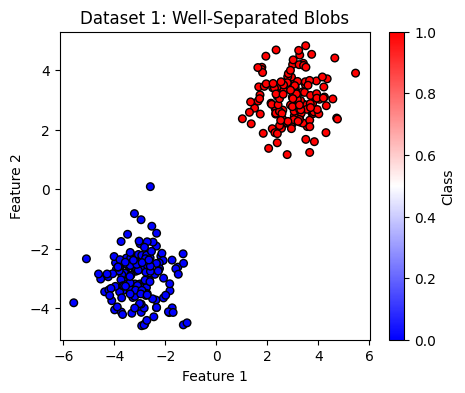

Dataset shape: (300, 2), Classes: [0 1]


In [14]:
# two blobs placed far apart in feature space
X1, y1 = make_blobs(
    n_samples=300,
    centers=[[-3, -3], [3, 3]],  # centers far apart
    cluster_std=0.8,              # slow spread, blobs tight, not spread out
    random_state=SEED
)

#scatter plot to check if it looks right before running classifiers
plt.figure(figsize=(5, 4))
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='bwr', edgecolors='k', s=30)
plt.title('Dataset 1: Well-Separated Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.show()

print(f'Dataset shape: {X1.shape}, Classes: {np.unique(y1)}')

## Step 1: Split Dataset 1 into Train and Test

Need to split data, will use 70% for training and 30% for testing

**need to remember:** never fit a model on test data. The test set is only used to evaluate after fitting on the training set.

In [9]:
# split: 70% train 30% test
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.3, random_state=SEED
)

print(f'Training samples: {len(X1_train)}')
print(f'Testing samples:  {len(X1_test)}')

Training samples: 210
Testing samples:  90


## Step 2: Fitting and Classification reports on Dataset 1

For each classifier on D1:
1. **Fit** on training data only (model never sees test data during training)
2. **Evaluate training data performance** — check for model fit/memorization
3. **Evaluate test data performance**

The `classification_report` prints precision, recall, f1-score, and accuracy for each class

In [10]:
#call 'fresh' classifiers
clf1_fitted = {}

for name, clf in get_classifiers().items():

    # part1: fit only on training data
    clf.fit(X1_train, y1_train)

    # part2: predict on training data (shows how well the model learned the training set)
    y1_train_pred = clf.predict(X1_train)

    # part3: predict on test data (shows how well the model generalizes to unseen data)
    y1_test_pred = clf.predict(X1_test)

    print(f"\n{'='*55}")
    print(f'  Classifier: {name}')
    print(f"{'='*55}")

    # part4: classification report for training
    print('\n>> Training evaluation (fit on train, predict on train):')
    print(classification_report(y1_train, y1_train_pred, zero_division=0))

    # part5: classification report for testing
    print('>> Testing evaluation (fit on train, predict on test):')
    print(classification_report(y1_test, y1_test_pred, zero_division=0))

    # saving fitted model to use for boundary plotting below
    clf1_fitted[name] = clf


  Classifier: Naive Bayes

>> Training evaluation (fit on train, predict on train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00       107

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210

>> Testing evaluation (fit on train, predict on test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        43

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90


  Classifier: Logistic Reg

>> Training evaluation (fit on train, predict on train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           

## Step 3: Visualize Decision Boundaries for Dataset 1

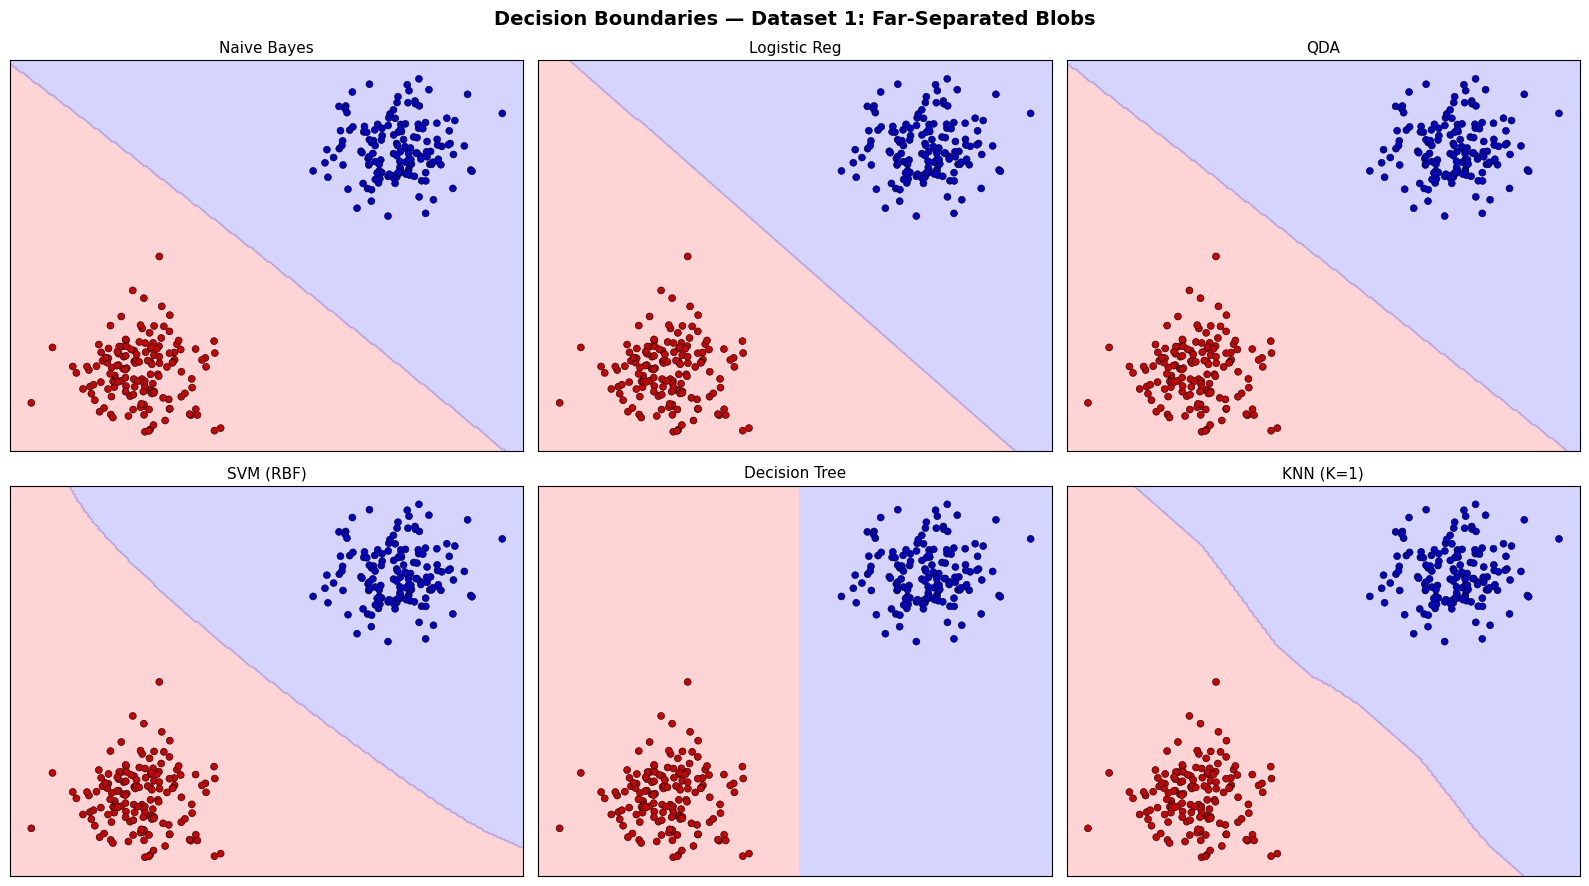

In [11]:
plot_decision_boundaries(X1, y1, clf1_fitted, 'Dataset 1: Far-Separated Blobs')

## Observed - Dataset 1

**Result:** All 6 classifiers showed near-perfect on both train and test sets

**Reason:** The clusters are widely separated with no overlap. Logistic Regression easily finds a linear boundary, while KNN and Decision Trees create more complex, jagged boundaries. Because of the clear "empty space" between classes, even the simplest model separates them perfectly


## Generate Dataset 2

- Need to make Logistic Regression do poorly while QDA, SVM, Decision Tree, and KNN do well

- Linear models can only separate data with a straight line. By using `make_circles` (with `factor=0.4` and `noise=0.1`), we create a "ring-within-a-ring" structure that requires a curved boundary

- QDA works because it can fit quadratic (curved) surfaces, allowing it to approx inner circular boundaries




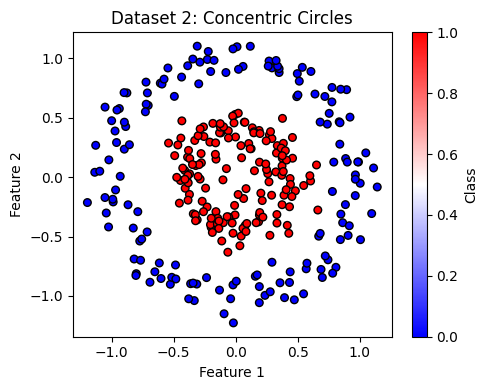

Dataset shape: (300, 2), Classes: [0 1]


In [15]:
# inner circle (class 1) surrounded by outer ring (class 0)
X2, y2 = make_circles(
    n_samples=300,
    noise=0.1, #for realism
    factor=0.4,    # inner circle is 40% the size of outer
    random_state=SEED
)

plt.figure(figsize=(5, 4))
plt.scatter(X2[:, 0], X2[:, 1], c=y2, cmap='bwr', edgecolors='k', s=30)
plt.title('Dataset 2: Concentric Circles')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.tight_layout()
plt.show()

print(f'Dataset shape: {X2.shape}, Classes: {np.unique(y2)}')

## Step 1: Split Dataset 2 into Train and Test

In [16]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.3, random_state=SEED
)

print(f'Training samples: {len(X2_train)}')
print(f'Testing samples:  {len(X2_test)}')

Training samples: 210
Testing samples:  90


## Step 2: Fitting and Classification reports on Dataset 2

Same method as D1: each classifer will have fit, evaluate training, test data performance, and outputs `classification_report`


In [17]:
clf2_fitted = {}

for name, clf in get_classifiers().items():

    #fit on training data only
    clf.fit(X2_train, y2_train)

    #predict on training data
    y2_train_pred = clf.predict(X2_train)

    #predict on test data
    y2_test_pred = clf.predict(X2_test)

    print(f"\n{'='*55}")
    print(f'  Classifier: {name}')
    print(f"{'='*55}")

    print('\n>> Training evaluation (fit on train, predict on train):')
    print(classification_report(y2_train, y2_train_pred, zero_division=0))

    print('>> Testing evaluation (fit on train, predict on test):')
    print(classification_report(y2_test, y2_test_pred, zero_division=0))

    clf2_fitted[name] = clf


  Classifier: Naive Bayes

>> Training evaluation (fit on train, predict on train):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       112
           1       1.00      0.93      0.96        98

    accuracy                           0.97       210
   macro avg       0.97      0.96      0.97       210
weighted avg       0.97      0.97      0.97       210

>> Testing evaluation (fit on train, predict on test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        52

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90


  Classifier: Logistic Reg

>> Training evaluation (fit on train, predict on train):
              precision    recall  f1-score   support

           0       0.49      0.85      0.62       112
           

## Step 3: Visualize Decision Boundaries for Dataset 2

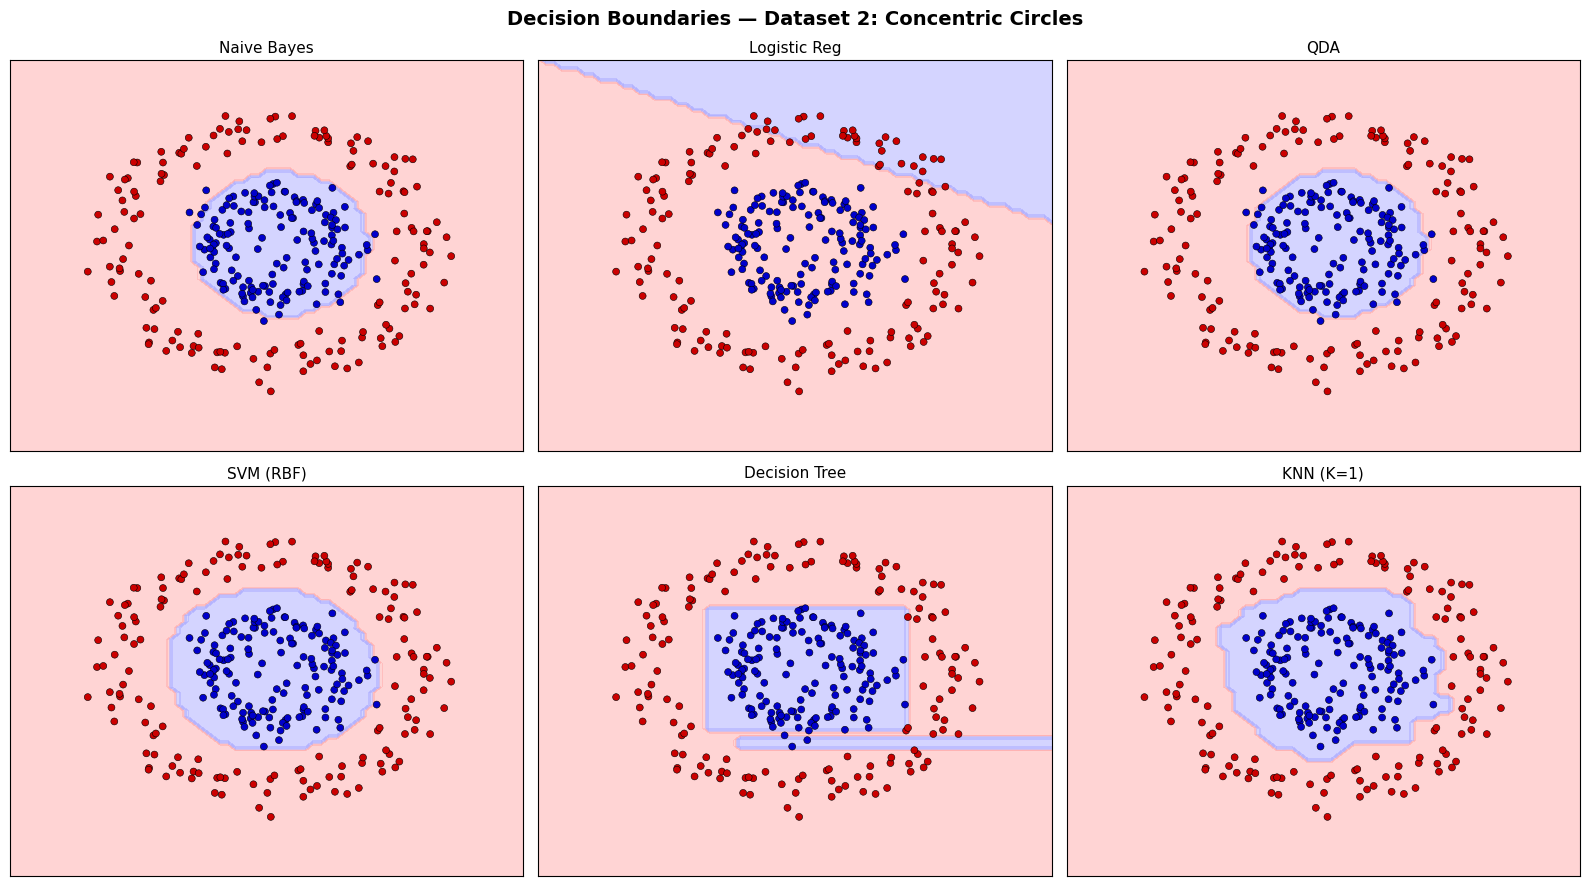

In [ ]:
plot_decision_boundaries(X2, y2, clf2_fitted, 'Dataset 2: Concentric Circles')

## Observed — Dataset 2

**Result:** Logistic regression has ~50% accurary. Fails because the straight line cant separate circular rings. Will always cut diagnolly and misclassify either half inner/outer circle

- QDA succeeds because fits the quadratic surface
- SVM (RBF) suceeds because  its kernel naturally calculates radial distance from a cente

Linear models have inability to capture non-linear data; no amount of altering can change this fundamental limitation



## Generate Dataset 3

Need to make Decision Tree and KNN overfit (high training/low test accuracy, while Logistic regression generalizes better

Overfitting happens when a model memorizes the training data rather than learning the pattern

- KNN (K=1): Predicts every nearest training point, but struggles on new data
- Decision Trees: Create overly complex splits(overfit) to isolate noisy points
- Logistic Regression: Does better by ignoring noise and finding stable dividing line

Will use two heavy overlapping classes (`make_blobs` + `cluster_std`)


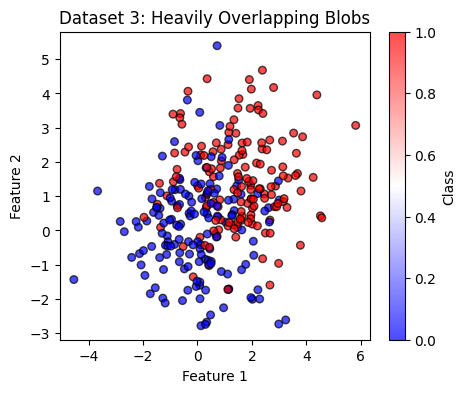

Dataset shape: (300, 2), Classes: [0 1]


In [18]:
#blobs with close centers and high spread = heavy class overlap
X3, y3 = make_blobs(
    n_samples=300,
    centers=[[0, 0], [1.5, 1.5]],  # centers are close
    cluster_std=1.4,                # high spread = classes bleed into each other
    random_state=SEED
)

plt.figure(figsize=(5, 4))
plt.scatter(X3[:, 0], X3[:, 1], c=y3, cmap='bwr', edgecolors='k', s=30, alpha=0.7)
plt.title('Dataset 3: Heavily Overlapping Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')

plt.show()

print(f'Dataset shape: {X3.shape}, Classes: {np.unique(y3)}')

## Step 1: Split Dataset 3 into Train and Test

In [19]:
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.3, random_state=SEED
)

print(f'Training samples: {len(X3_train)}')
print(f'Testing samples:  {len(X3_test)}')

Training samples: 210
Testing samples:  90


## Step 2: Fitting and Classification reports on Dataset 3

Same method as D2: each classifer will have fit, evaluate training, test data performance, and outputs `classification_report`

The gap between training and test accuracy shows overfitting



In [20]:
clf3_fitted = {}

for name, clf in get_classifiers().items():

    #fit on training data only
    clf.fit(X3_train, y3_train)

    #predict on training data
    y3_train_pred = clf.predict(X3_train)

    #predict on test data
    y3_test_pred = clf.predict(X3_test)

    print(f"\n{'='*55}")
    print(f'  Classifier: {name}')
    print(f"{'='*55}")

    print('\n>> Training evaluation (fit on train, predict on train):')
    print(classification_report(y3_train, y3_train_pred, zero_division=0))

    print('>> Testing evaluation (fit on train, predict on test):')
    print(classification_report(y3_test, y3_test_pred, zero_division=0))

    clf3_fitted[name] = clf


  Classifier: Naive Bayes

>> Training evaluation (fit on train, predict on train):
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       103
           1       0.77      0.77      0.77       107

    accuracy                           0.76       210
   macro avg       0.76      0.76      0.76       210
weighted avg       0.76      0.76      0.76       210

>> Testing evaluation (fit on train, predict on test):
              precision    recall  f1-score   support

           0       0.84      0.77      0.80        47
           1       0.77      0.84      0.80        43

    accuracy                           0.80        90
   macro avg       0.80      0.80      0.80        90
weighted avg       0.80      0.80      0.80        90


  Classifier: Logistic Reg

>> Training evaluation (fit on train, predict on train):
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       103
           

## Step 3: Visualize Decision Boundaries for Dataset 3

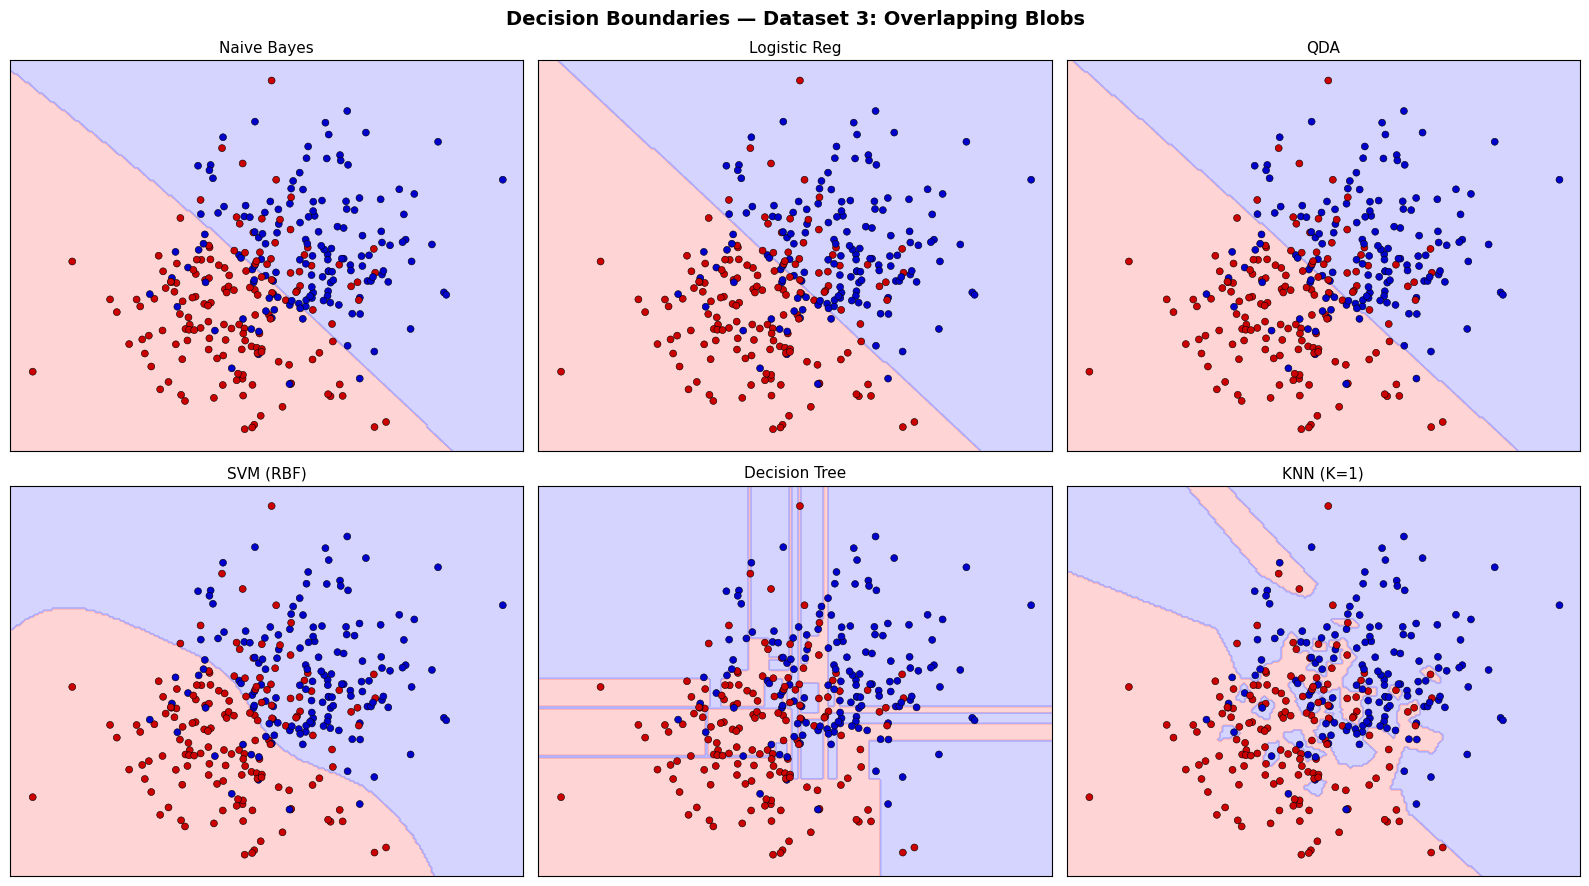

In [ ]:
plot_decision_boundaries(X3, y3, clf3_fitted, 'Dataset 3: Overlapping Blobs')

## Observed — Dataset 3

**Result:** Decision Trees and KNN (K=1) show high training accuracy but worse test accuracy — proving overfitting performance

- KNN(K=1): Always gets training data right because the nearest neighbor of any training point is itself, predicting the correct class everytime. On test data, it fails in the overlapping region where both classes are mixed

- Decision Tree: A tree without contraints keeps splitting until it separates every training point, creating jagged boundaries that capture random noise rather than real patterns

- Logistic Regression: The simple linear boundary finds the best dividing boundary — less accurate on training data, but stable and reliable on unseen data

Looking at KNN and Decision Trees, they have jagged regions that wrap around individual training points. Logistic Regression draws one clean diagonal line.
